In [19]:
import pandas as pd
data = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Assuming data is a pandas DataFrame and 'Review Text' is a column containing text data
text_data = data['Review Text']

# Fill missing (NaN) values with an empty string
text_data = text_data.fillna('')

# Tokenizing and preprocessing the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(text_data)

# Fitting an LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Getting the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


Topic 1: like, fabric, look, just, really, love, fit, dress, shirt, little
Topic 2: dress, size, small, fit, wear, ordered, petite, love, medium, large
Topic 3: store, tried, online, like, saw, color, dress, retailer, price, sale
Topic 4: size, fit, jeans, love, wear, pants, great, color, bought, perfect
Topic 5: love, great, soft, wear, sweater, comfortable, perfect, color, shirt, like


In [21]:
from gensim.models import Word2Vec
import pandas as pd

text_data = data['Review Text']

# Fill missing (NaN) values with an empty string
text_data = text_data.fillna('')

# Tokenizing and preprocess the text data
sentences = [text.split() for text in text_data]

# Training a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1, workers=4)

# Finding similar words to gender-specific terms
similar_words = model.wv.most_similar('gender', topn=5)
print("Words similar to 'gender':", similar_words)


Words similar to 'gender': [('gushing,', 0.9622914791107178), ('stylist,', 0.9602112770080566), ('accidents.', 0.9599695205688477), ('super-flattering', 0.9596951603889465), ('michelin', 0.9596884846687317)]


In [27]:
import networkx as nx

# Create a directed graph to represent content propagation
G = nx.DiGraph()

# Adding nodes for users and reviews
for user_id, review in zip(data['Clothing ID'], data['Review Text']):
    G.add_node(user_id, type='user')
    G.add_node(review, type='review')
    G.add_edge(user_id, review)

# choosing a subset of nodes based on our analysis needs
subset_nodes = data['Clothing ID'].head(100000)  #"IOPub data rate exceeded so taking 100000 nodes
degree_centrality = nx.degree_centrality(G)

# Calculating degree centrality for the selected subset of nodes
subset_degree_centrality = {node: degree_centrality[node] for node in subset_nodes}

# Sorting the subset_degree_centrality dictionary by degree centrality values in descending order
sorted_subset_degree_centrality = {k: v for k, v in sorted(subset_degree_centrality.items(), key=lambda item: item[1], reverse=True)}

# Printing the top 5 nodes with the highest degree centrality
top_5_nodes = list(sorted_subset_degree_centrality.keys())[:5]
top_5_degree_centrality = {node: sorted_subset_degree_centrality[node] for node in top_5_nodes}

print("Top 5 Nodes with Highest Degree Centrality:")
for node, centrality in top_5_degree_centrality.items():
    print(f"Node: {node}, Degree Centrality: {centrality}")


Top 5 Nodes with Highest Degree Centrality:
Node: 1078, Degree Centrality: 0.041442953020134225
Node: 862, Degree Centrality: 0.03267617449664429
Node: 1094, Degree Centrality: 0.03087248322147651
Node: 1081, Degree Centrality: 0.023531879194630873
Node: 872, Degree Centrality: 0.02181208053691275


In [23]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Initializing the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# function to calculate sentiment scores for a text
def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment

# list to store sentiment scores for each topic
topic_sentiments = []

# sentiment scores for reviews within each topic
for topic_idx, topic in enumerate(lda.components_):
    topic_reviews = text_data[lda.transform(dtm).argmax(axis=1) == topic_idx]
    sentiment_scores = topic_reviews.apply(get_sentiment)
    topic_sentiments.append(sentiment_scores)

# Displaying sentiment scores for each topic
for topic_idx, sentiment_scores in enumerate(topic_sentiments):
    # Initializing variables to accumulate sentiment components
    total_positive = 0
    total_negative = 0
    total_neutral = 0
    total_compound = 0

    for sentiment in sentiment_scores:
        total_positive += sentiment['pos']
        total_negative += sentiment['neg']
        total_neutral += sentiment['neu']
        total_compound += sentiment['compound']

    # Calculating the mean sentiment for each component
    mean_positive = total_positive / len(sentiment_scores)
    mean_negative = total_negative / len(sentiment_scores)
    mean_neutral = total_neutral / len(sentiment_scores)
    mean_compound = total_compound / len(sentiment_scores)

    print(f"Topic {topic_idx + 1} Sentiment (Positive): {mean_positive}")
    print(f"Topic {topic_idx + 1} Sentiment (Negative): {mean_negative}")
    print(f"Topic {topic_idx + 1} Sentiment (Neutral): {mean_neutral}")
    print(f"Topic {topic_idx + 1} Sentiment (Compound): {mean_compound}")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Topic 1 Sentiment (Positive): 0.16263663663663716
Topic 1 Sentiment (Negative): 0.04574941608274948
Topic 1 Sentiment (Neutral): 0.6506331331331322
Topic 1 Sentiment (Compound): 0.5344055055055045
Topic 2 Sentiment (Positive): 0.21863017543859653
Topic 2 Sentiment (Negative): 0.030085614035087718
Topic 2 Sentiment (Neutral): 0.7512754385964934
Topic 2 Sentiment (Compound): 0.7641682807017506
Topic 3 Sentiment (Positive): 0.18024547627176507
Topic 3 Sentiment (Negative): 0.05146329805394334
Topic 3 Sentiment (Neutral): 0.7682939569819065
Topic 3 Sentiment (Compound): 0.5770646978490953
Topic 4 Sentiment (Positive): 0.25577896871378875
Topic 4 Sentiment (Negative): 0.024613267670915435
Topic 4 Sentiment (Neutral): 0.7196112398609483
Topic 4 Sentiment (Compound): 0.8169260718424094
Topic 5 Sentiment (Positive): 0.3085967473664745
Topic 5 Sentiment (Negative): 0.01991073738680473
Topic 5 Sentiment (Neutral): 0.6714869709850313
Topic 5 Sentiment (Compound): 0.8492143226760307


In [24]:
gender_bias_keywords = ['gender', 'stereotype', 'biased_word', 'masculine', 'feminine', 'manly', 'girly', 'male', 'female']

# Initializing a dictionary to store gender bias detection results for each topic
gender_bias_in_topics = {}

# Iterating through 5 topics and analyzing reviews for gender bias
for topic_idx in range(5):
    topic_reviews = data['Review Text'][lda.transform(dtm).argmax(axis=1) == topic_idx]
    gender_bias_detection = topic_reviews.apply(detect_gender_bias_in_topic)
    gender_bias_in_topics[f"Topic {topic_idx + 1}"] = gender_bias_detection.sum() / len(gender_bias_detection)

# Displaying gender bias detection results for each of the 5 topics
for topic, bias_score in gender_bias_in_topics.items():
    print(f"{topic} Gender Bias Score: {bias_score:.2%}")


Topic 1 Gender Bias Score: 1.43%
Topic 2 Gender Bias Score: 2.61%
Topic 3 Gender Bias Score: 1.09%
Topic 4 Gender Bias Score: 2.20%
Topic 5 Gender Bias Score: 3.03%


Topic 5 has maximun gender bias

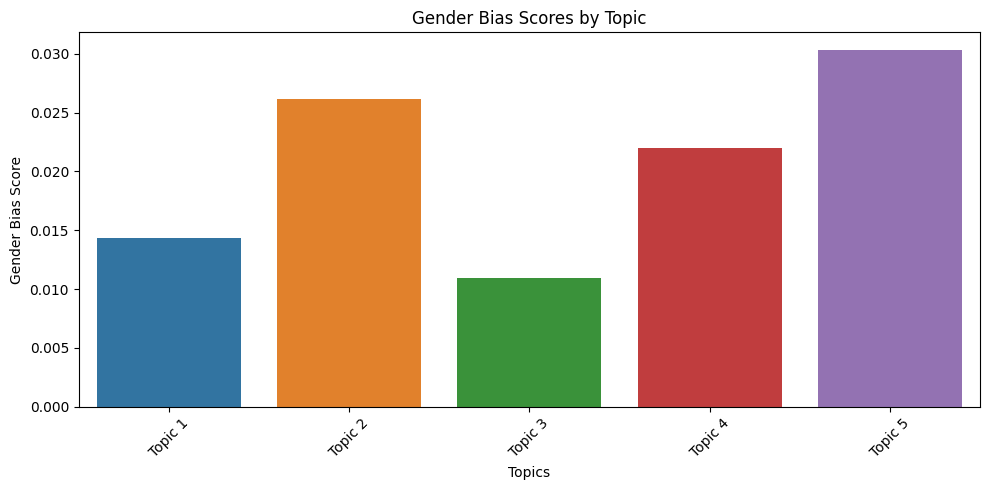

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Gender Bias Scores Visualization (Bar Chart)
topics = [f"Topic {topic_idx + 1}" for topic_idx in range(5)]
bias_scores = []

for topic_idx in range(5):
    topic_reviews = data['Review Text'][lda.transform(dtm).argmax(axis=1) == topic_idx]
    gender_bias_detection = topic_reviews.apply(detect_gender_bias_in_topic)
    bias_score = gender_bias_detection.mean()
    bias_scores.append(bias_score)

plt.figure(figsize=(10, 5))
sns.barplot(x=topics, y=bias_scores)
plt.title('Gender Bias Scores by Topic')
plt.xlabel('Topics')
plt.ylabel('Gender Bias Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
